In [2]:
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [3]:
# path_of_lib = '/home/ksn38/symfony-6.3/'
# path_of_lib = 'C:\\Python37\\Lib\\site-packages\\bokeh\\'
# path_of_lib = 'E:\\Temp\\bitrix\\'
path_of_lib = 'C:\\Users\\ksn\\frameworks\\angular-main\\'
# path_of_lib = 'C:\\Users\\ksn\\stable-diffusion-webui\\'

In [4]:
if os.name == "posix":
    lib = path_of_lib.split('/')[-2]
elif os.name == "nt":
    lib = path_of_lib.split('\\')[-2]

In [5]:
list_classes = []
list_classes_for_graph = []
list_classes_for_html = []
list_classes_for_html.append('<!DOCTYPE html><html><head><meta charset="utf-8"><title></title>\
<style>body{background-color: #1b232a;}div{color: #a0a0a0;}a{color: #55e1e6;}span{color: #dadada;}\
</style></head><span><i>The number is amount of subclasses</i></span><br><br>')

In [6]:
#open file and get names classes with regex
def open_and_re(path, list_classes, list_classes_for_graph, list_classes_for_html):
    with open(path, 'r', encoding='utf-8') as file:
        try:
            classes = re.findall('^class\s.*|^interface.*|^abstract.*', file.read(), re.MULTILINE)
        except UnicodeDecodeError:
            classes = []
        for i in classes:
            i = i.replace('\\', '.')
            #class is taken for graph and counter at least 4 characters in name 
            list_1_or_more_classes = re.findall('\w{4,}\.*', i)
            list_1_or_more_classes_origin = list_1_or_more_classes.copy()
            for k in list_1_or_more_classes_origin:
                if k in {'class', 'extends', 'interface', 'abstract', 'implements'} \
                or k[-1] == '.':
                    list_1_or_more_classes.remove(k)
            list_classes.extend(list_1_or_more_classes)
            if len(list_1_or_more_classes) > 1:
                for j in list_1_or_more_classes[1:]:
                    list_classes_for_graph.append([list_1_or_more_classes[0], j])
        for c in classes:
            c = c.replace('{', '')
            c = c.replace('}', '')
            c = c.replace('<', '&lt')
            c = c.replace('>', '&gt')
            list_classes_for_html.append(f'<div>{c}</div>')
        if len(classes) > 0:
            list_classes_for_html.append(f'<a href="{path}">{path}</a>')
            
#run previous function on multiple files
def printer(tuple_from_oswalk):
    files = tuple_from_oswalk[2]
    for f in files:
        if tuple_from_oswalk[0][-1] != '/' and f[-3:] in {'php', '.js', '.ts', '.py'}:
            open_and_re(tuple_from_oswalk[0] + '/' + f, list_classes, \
                        list_classes_for_graph, list_classes_for_html)
        elif tuple_from_oswalk[0][-1] == '/' and f[-3:] in {'php', '.js', '.ts', '.py'}:
            open_and_re(tuple_from_oswalk[0] + f, list_classes, \
                        list_classes_for_graph, list_classes_for_html)

In [7]:
#run previous function on multiple directories
for i in os.walk(path_of_lib):
    printer(i)

class_counter = Counter(list_classes)

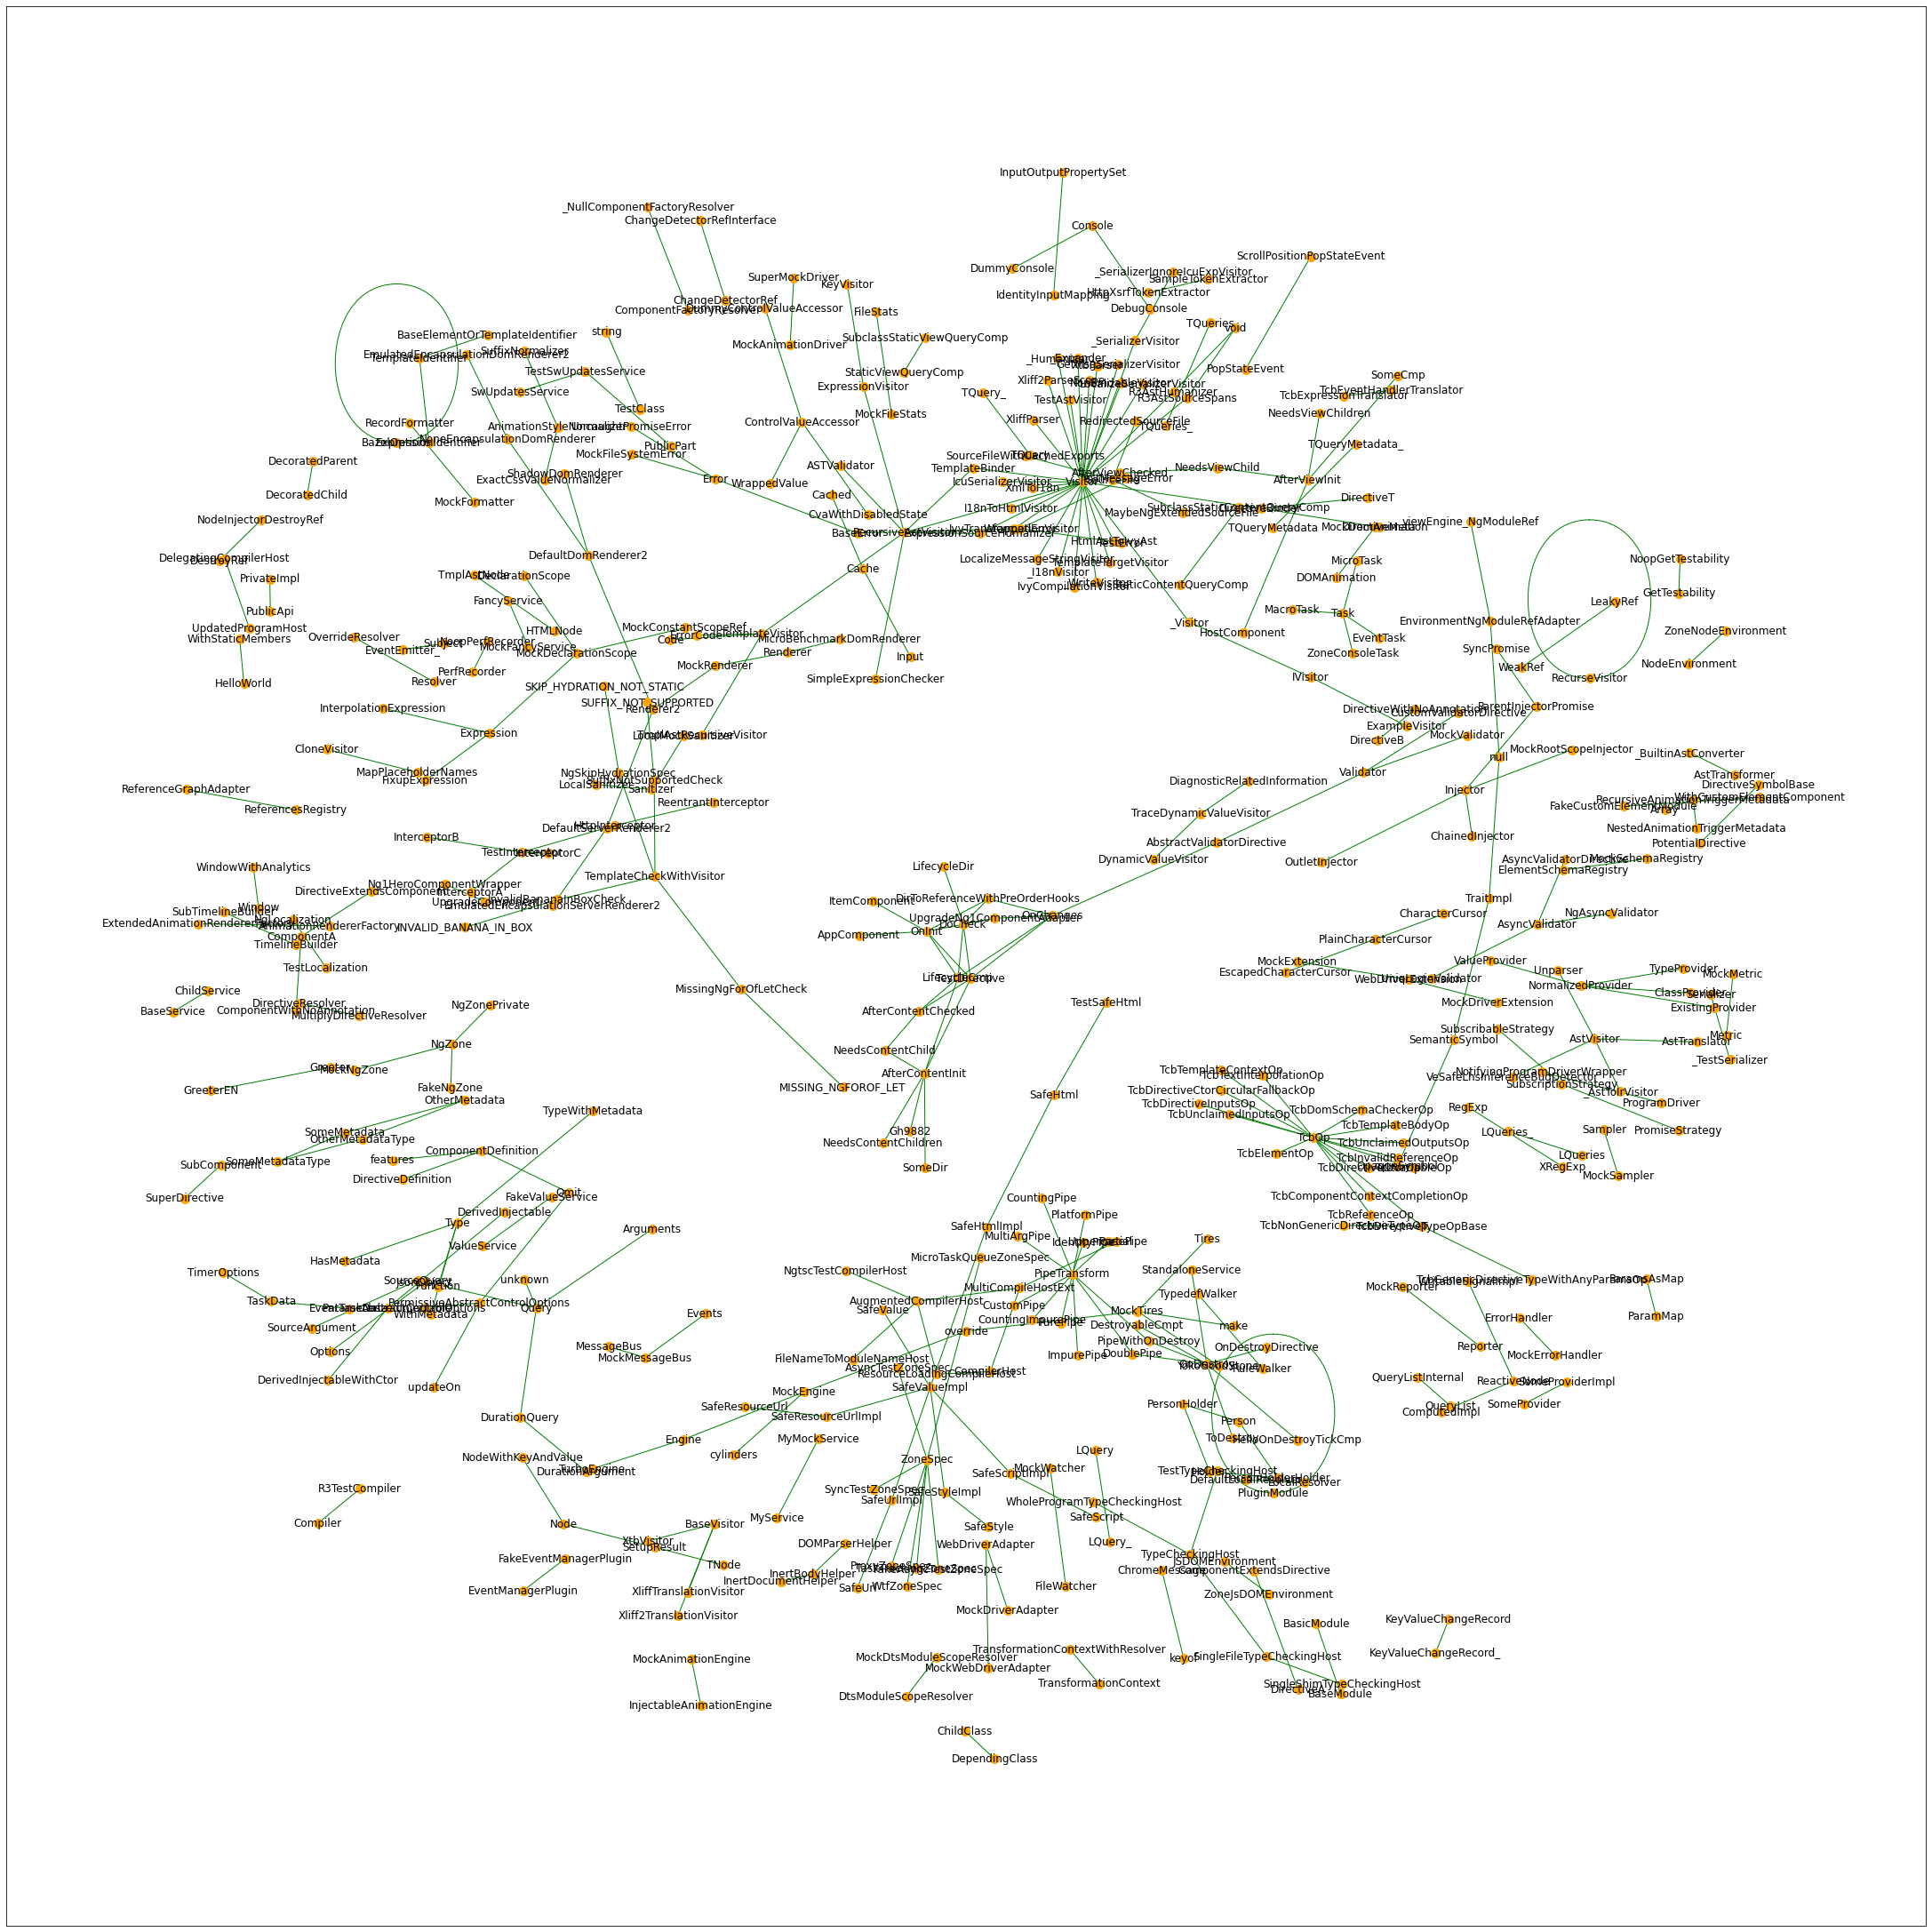

In [17]:
#create graph
size = 30

fig, ax = plt.subplots()
fig.set_size_inches(size, size)
fig.patch.set_visible(False)
#ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

G = nx.Graph()

for i in list_classes_for_graph:
    G.add_edge(*i, minlen = 1000)

pos = nx.spring_layout(G, k=0.07, iterations=25)
nx.draw_networkx(G, pos, node_color='orange', edge_color='g', node_size=100)

plt.savefig(f'{lib}.png')

In [9]:
#dict is needed for red color in html 
class_counter_gt_1 = {}

for i in class_counter.items():
    if i[1] > 1:
        class_counter_gt_1[i[0]] = i[1]
    
class_counter_gt_1_origin = class_counter_gt_1.copy()

In [10]:
list_classes_for_html.append('<br><span><b>Classes counter:</b></span><br>')
for i in sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True):
    list_classes_for_html.append(f'<a href="#{i[0]}">{i[0]}({i[1] - 1})</a>&nbsp&nbsp')

In [11]:
#values of class_counter_gt_1 have been changed for convenient colors
dict_line = dict(zip(sorted(set(class_counter_gt_1.values()), reverse=True), \
                     np.linspace(0, 255, len(set(class_counter_gt_1.values())))))

for k, v in class_counter_gt_1.items():
    class_counter_gt_1[k] = dict_line[v]

In [12]:
#added colors and counter values in html
for i in range(len(list_classes_for_html)):
    try:
        c = re.findall('class\s\w+|interface\s\w+\s\w+', list_classes_for_html[i])
    except:
        c = []
    if len(c) != 0:
        for j in class_counter_gt_1:
            if j == c[0].split(' ')[1]:
                list_classes_for_html[i] = '<div style="color: rgb(' + \
                str(class_counter_gt_1[j]) + ' ,255 ,' + str(class_counter_gt_1[j]) + \
                f')"  id="{j}">' + list_classes_for_html[i][5:-6] + \
                f' = {class_counter_gt_1_origin[j] - 1}</div>'

In [13]:
html_file = open(lib + '.html', 'w')
html_file.write('\n'.join(map(str, list_classes_for_html)))
html_file.close()

In [14]:
#print(sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True))

In [15]:
#print(sorted(class_counter_gt_1.items(), key= lambda item: item[1], reverse=True))